In [1]:
import awkward as ak
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema, BaseSchema
from coffea import util
import numpy as np
import numba as nb
import uproot as up
from coffea import hist as coffea_hist
 
# from coffea import hist,processor
from coffea import processor
from coffea.nanoevents.methods import candidate
ak.behavior.update(candidate.behavior)
import matplotlib.pyplot as plt
import mplhep as hep
import time

from hist import Hist, axis
import hist

import pickle

hep.cms.style.CMS["xtick.major.width"]=2
hep.cms.style.CMS["ytick.major.width"]=2
hep.cms.style.CMS["xtick.minor.width"]=2
# hep.cms.style.CMS["xtick.minor.visible"]=False
hep.cms.style.CMS["ytick.minor.width"]=2
hep.cms.style.CMS["xtick.major.size"]=14
hep.cms.style.CMS["xtick.minor.size"]=7
hep.cms.style.CMS["ytick.major.size"]=14
hep.cms.style.CMS["ytick.minor.size"]=7
hep.cms.style.CMS["legend.handlelength"]=1
hep.cms.style.CMS["legend.handleheight"]=1
hep.cms.style.CMS["axes.linewidth"]=3
plt.style.use(hep.style.CMS)
# plt.style.use(hep.style.ROOT)


## get_bands, ratio_hist, get_true_err

In [2]:
def get_bands(_up,_down,_edges):
    xaxis,up,down=[],[],[]
    for i,j in zip(_up,_down): 
        up.append(i)
        down.append(j)
        up.append(i)
        down.append(j)
    for i in _edges: 
        xaxis.append(i)
        xaxis.append(i)
    xaxis=xaxis[1:-1]
    return xaxis,up,down

def ratio_hist(content1, yerr1, content2, yerr2, _edges):
    # content1, yerr1 = hist1.values(), np.sqrt(hist1.variances())
    # content2, yerr2 = hist2.values(), np.sqrt(hist2.variances())
    # _edges=hist1.axes[0].edges
    content=[]
    yerr=[]
    # if you only show one error, then you may want to use the error propagation
    #for i,ibin in enumerate(content1):
    #    try:
    #        tmp_con=(content2[i]/content1[i])
    #        tmp_err=np.sqrt(tmp_con*tmp_con*(pow(yerr1[i]/content1[i],2)+pow(yerr2[i]/content2[i],2)))
    #        content.append(tmp_con)
    #        yerr.append(tmp_err)
    #    except:
    #        content.append(0)
    #        yerr.append(0)        

    # for the ratio plot, you show both the error of the numerator and the error of the denominator
    for i,ibin in enumerate(content1):
        try:
            if content1[i]>0:
                tmp_con = (content2[i]/content1[i])
                # tmp_err = (yerr2[i]/content2[i])*(content2[i]/content1[i])
                tmp_err = (yerr2[i]/content1[i])
                content.append(tmp_con)
                yerr.append(tmp_err)
            else:
                content.append(0)
                yerr.append(0)        
        except:
            content.append(0)
            yerr.append(0)        

    return np.array(content),np.array(yerr),np.array(_edges)

def get_true_err(central_val, stat_err, sys_up, sys_down):
    _up = central_val + np.sqrt(stat_err*stat_err+sys_up*sys_up)
    _down = central_val - np.sqrt(stat_err*stat_err+sys_down*sys_down)
    return _up,_down

## get_plot

In [3]:
def get_plot(region,channel,varibale,hists,year="2016",hist_scale=1.4,blind=False):
    lumi = {
        "2016": 36.33,
        "2017": 41.53,
        "ALL": 77.86,
    } 
    which_year = {
        "2016": "2016",
        "2017": "2017",
        "ALL": "2016+2017",
    } 
    hstyle = {
        'others':{'name':'Others','color':'#7fc97f'},
        'za_ewk':{'name':'EW W$\gamma$jj','color':'#beaed4'},
        'za_qcd':{'name':'W$\gamma$ QCD','color':'#fdc086'},
        'fake':{'name':'Fake $\gamma$','color':'cyan'},
        'data':{'name':'Data','color':'black'},
    }

    hdata_val = hists['data'].values()
    hdata_err = np.sqrt(hists['data'].variances())
    hpred_val = hists['total_pred'].values()
    hpred_err = np.sqrt(hists['total_pred'].variances())
    hpred_up_val = hists['total_pred'].values()
    hpred_down_val = hists['total_pred'].values()

    _up,_down = get_true_err(hpred_val, hpred_err, np.abs(hpred_up_val-hpred_val), np.abs(hpred_val-hpred_down_val))

    _edges = hists['data'].axes.edges[0]
    
    f, ax = plt.subplots(2,1,figsize=(8,8),gridspec_kw={'height_ratios': [3.1, 0.9]},sharex=True)
    
    sample_names = ['others','fake','za_qcd','za_ewk']
    # ax[0]
    xaxis,up,down = get_bands(_up,_down,_edges)
    ax[0].fill_between(xaxis,up,down,color='gray', alpha=0.25, zorder=2.5,edgecolor="black",linewidth=0, label='Pred. unc.', hatch="\\")
    hep.histplot([hists[i].values() for i in sample_names], bins=_edges, edges=False,histtype="fill", stack=True, color=[hstyle[i]['color'] for i in sample_names],label=[hstyle[i]['name'] for i in sample_names],linewidth=0,ax=ax[0])
    if not blind:
        hep.histplot(hdata_val, bins=_edges, yerr=hdata_err, edges=False,histtype="errorbar", stack=False, color='black',label=hstyle['data']['name'],marker='o',ax=ax[0], markersize=6, elinewidth=2) #
    ax[0].set_ylabel('Events/bin', ha='right', y=1.0)
    _ymax0 = max(hdata_val)
    _ymax0 = max(hpred_val) if _ymax0<max(hpred_val) else _ymax0
    ax[0].set_xlabel('', ha='right', x=1.0)
    ax[0].set_ylim(0,hist_scale*_ymax0)

    # set the legend
    leg_handles,leg_labels = ax[0].get_legend_handles_labels()
    # print(leg_handles,leg_labels)
    # the last two are uncertainty, data
    leg_handles_new = [leg_handles[-1]]
    leg_labels_new  = [leg_labels[-1]]
    for i in range(1,len(leg_handles)):
        leg_handles_new.append(leg_handles[i-1])
        leg_labels_new.append(leg_labels[i-1])
    ax[0].legend(leg_handles_new,leg_labels_new,loc='upper left', ncol=3, fontsize=17)
    
           
    # ax[0].tick_params(axis='x',which='both',length=0)
    # ax[1] ratio
    content,yerr,_edges=ratio_hist(hpred_val,hpred_err,hpred_val,hpred_err,_edges)
    xaxis1,up1,down1=get_bands(_up/hpred_val,_down/hpred_val,_edges)
    _ymax1 = max(yerr)
    _ymin1 = -_ymax1
    ax[1].fill_between(xaxis1,up1,down1,color='gray', alpha=0.25, zorder=1,edgecolor="black",linewidth=0, hatch="\\")
    ax[1].axhline(y=1,linestyle='--',linewidth=2,alpha=0.7,color='gray')
    content,yerr,_edges=ratio_hist(hpred_val,_up/hpred_val-1,hdata_val,hdata_err,_edges)
    _ymax1 = _ymax1 if _ymax1>max(content+yerr) else max(content+yerr)
    _ymin1 = _ymin1 if _ymin1<min(content-yerr) else min(content-yerr)
    # ax[1].set_ylim(max(0,1.33*(_ymin1-1)+1),1.33*(_ymax1-1)+1)
    if not blind:
        hep.histplot(content, bins=_edges, yerr=yerr,histtype="errorbar",ax=ax[1],marker='o',color="black", markersize=6,elinewidth=2) #,label="GE./Roc.-1"
    ax[1].set_ylabel(r'$\frac{Data}{Prediction}$', ha='center',fontsize=30)#va='baseline')
    ax[1].set_xlabel(hists['data'].axes.label[0], ha='right', x=1.0)
    ax[1].set_xlim(_edges[0],_edges[-1])
    # ax[1].set_ylim(0.48,1.52)
    plt.subplots_adjust(hspace=0.06)
    hep.cms.label(label=f"Preliminary: {region}, {channel}",loc=0,data=True,year=which_year[year],lumi=lumi[year],ax=ax[0],fontsize=15)
    # if not os.path.exists(save_path):
    #     os.makedirs(save_path)
    
    # if postfit:
    #     plt.savefig(f'{save_path}/postfit.png',bbox_inches='tight')
    #     plt.savefig(f'{save_path}/postfit.pdf',bbox_inches='tight')
    # else:
    #     plt.savefig(f'{save_path}/prefit.png',bbox_inches='tight')
    #     plt.savefig(f'{save_path}/prefit.pdf',bbox_inches='tight')
    # # hep.cms.lumitext(cate,ax[0])

## 2016

============> 2016: SR ALL mjj
============> 2016: SR ALL mll
============> 2016: SR ALL mllv1
============> 2016: SR ALL mjj_detajj
============> 2016: SR EB mjj
============> 2016: SR EB mll
============> 2016: SR EB mllv1
============> 2016: SR EB mjj_detajj
============> 2016: SR MB mjj
============> 2016: SR MB mll
============> 2016: SR MB mllv1
============> 2016: SR MB mjj_detajj
============> 2016: SR EE mjj
============> 2016: SR EE mll
============> 2016: SR EE mllv1
============> 2016: SR EE mjj_detajj
============> 2016: SR ME mjj
============> 2016: SR ME mll
============> 2016: SR ME mllv1
============> 2016: SR ME mjj_detajj
============> 2016: CR ALL lowmjj


/tmp/ipykernel_1651600/509861540.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, ax = plt.subplots(2,1,figsize=(8,8),gridspec_kw={'height_ratios': [3.1, 0.9]},sharex=True)


============> 2016: CR ALL mll
============> 2016: CR ALL mllv1
============> 2016: CR EB lowmjj
============> 2016: CR EB mll
============> 2016: CR EB mllv1
============> 2016: CR MB lowmjj
============> 2016: CR MB mll
============> 2016: CR MB mllv1
============> 2016: CR EE lowmjj
============> 2016: CR EE mll
============> 2016: CR EE mllv1
============> 2016: CR ME lowmjj
============> 2016: CR ME mll
============> 2016: CR ME mllv1


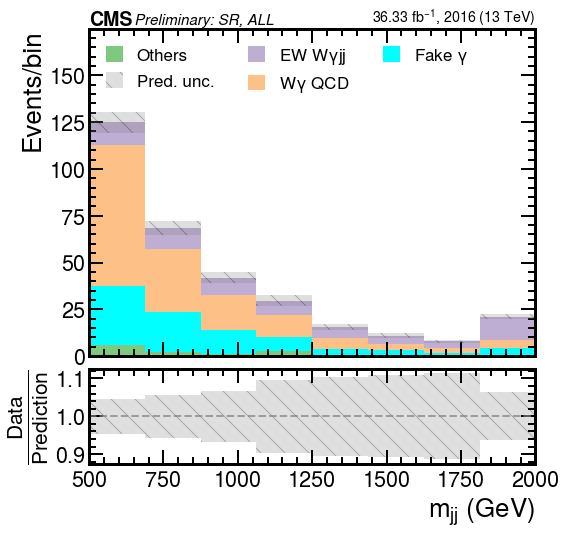

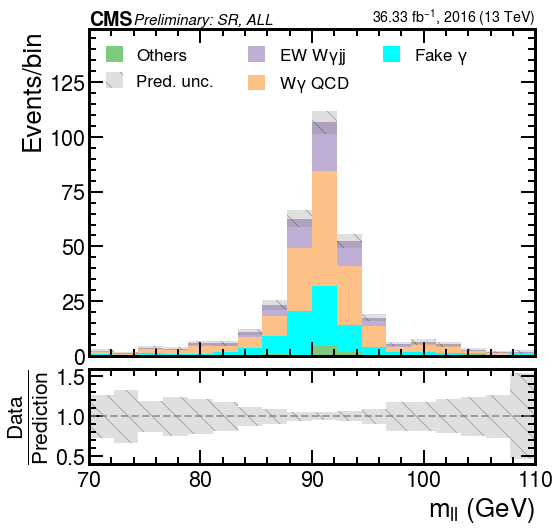

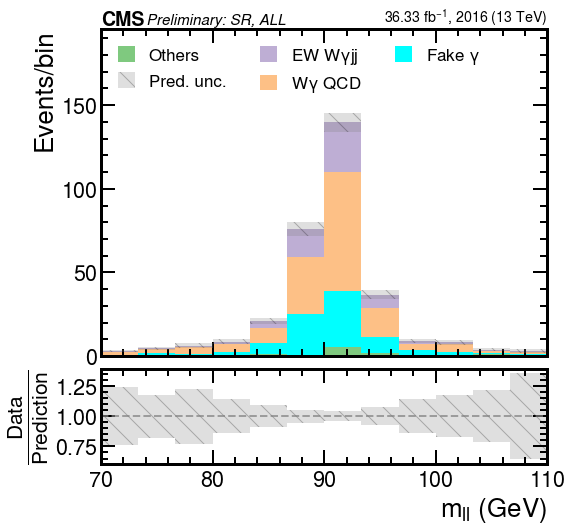

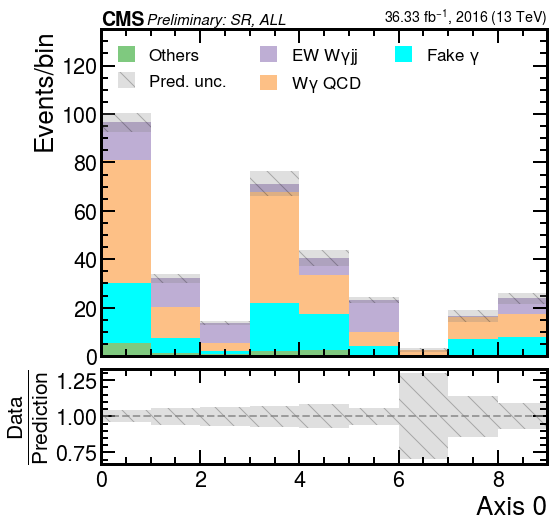

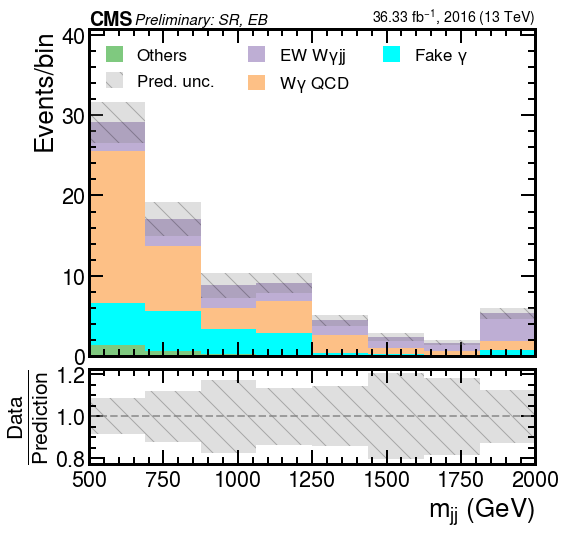

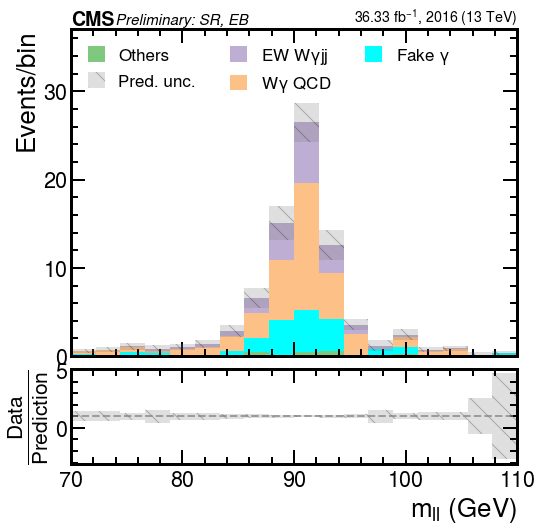

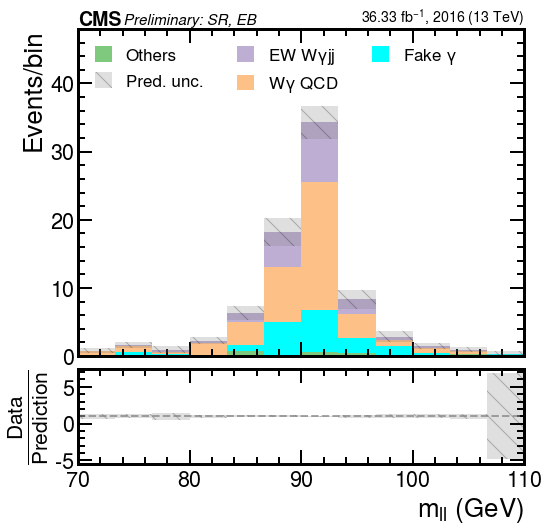

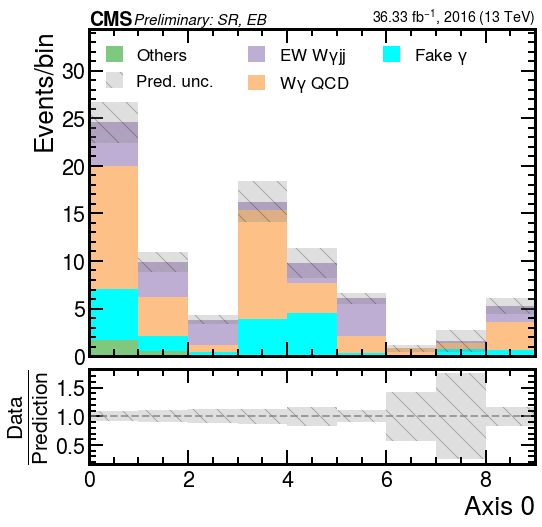

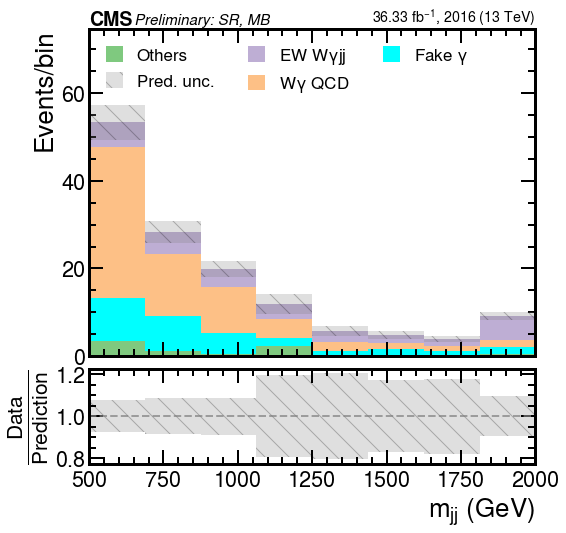

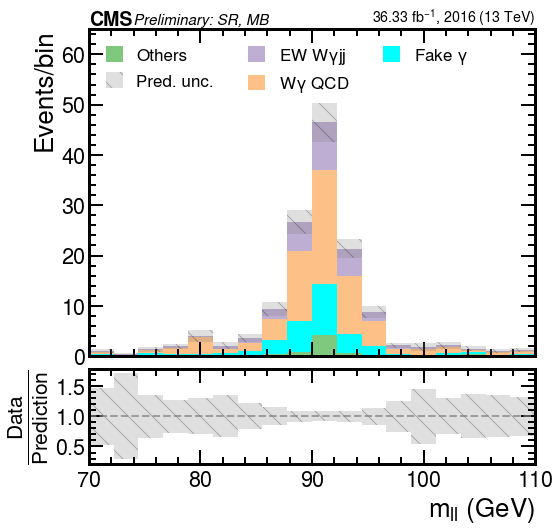

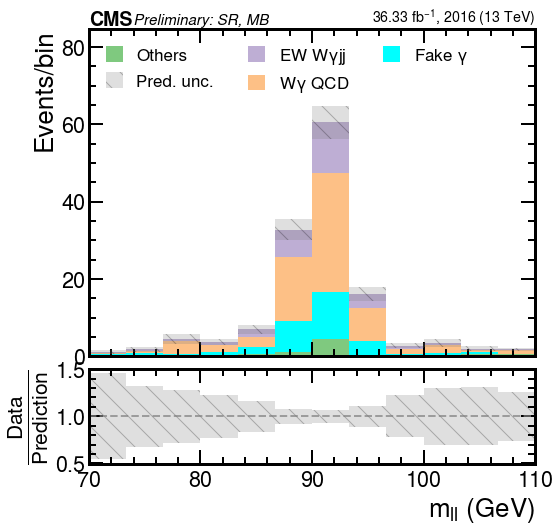

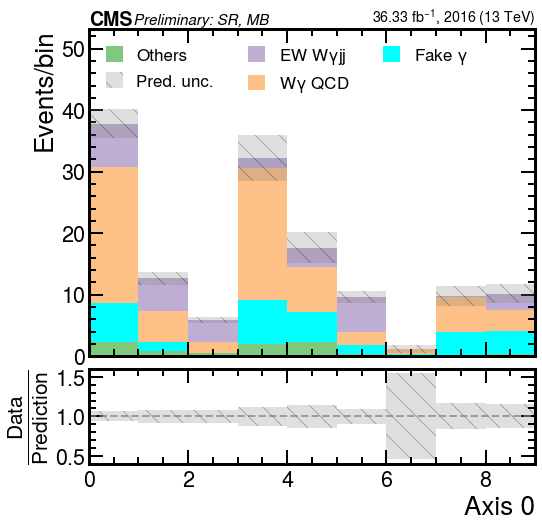

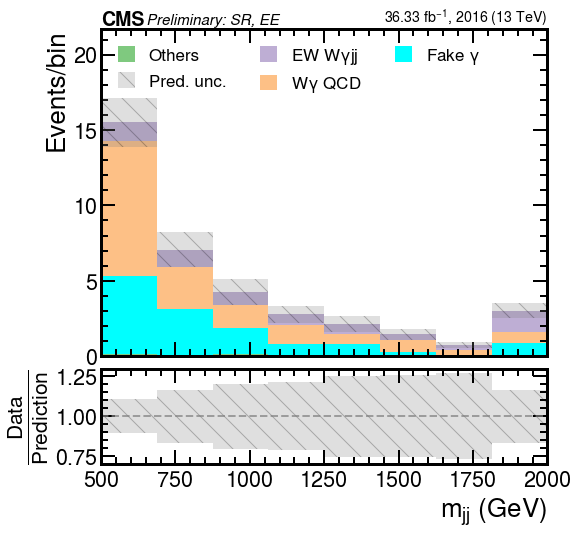

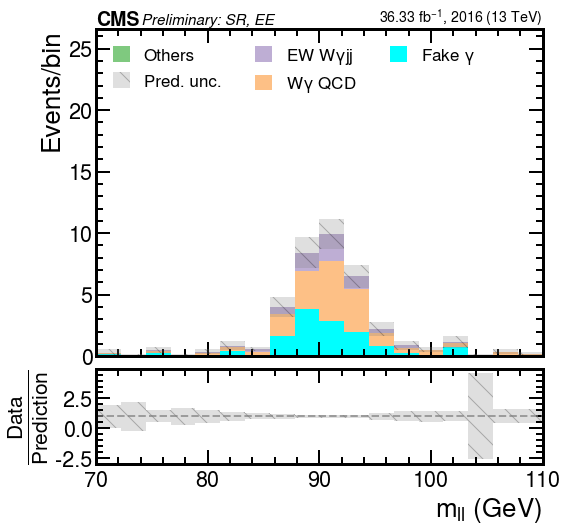

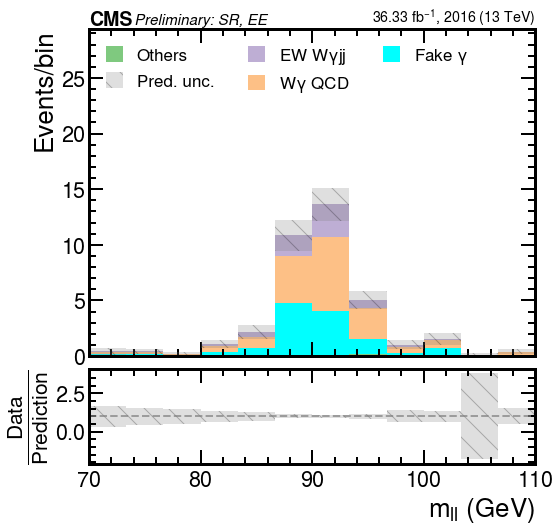

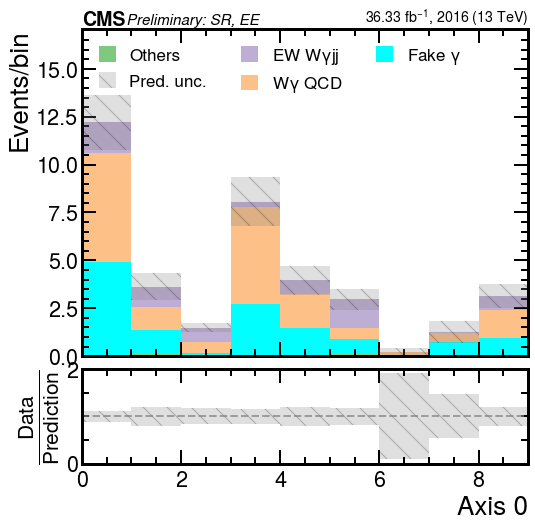

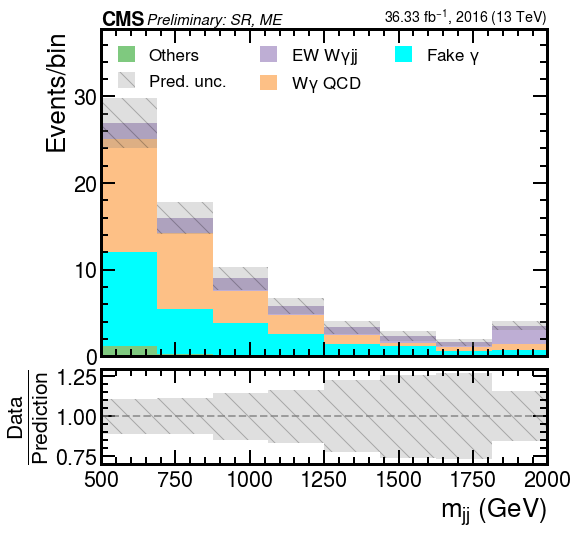

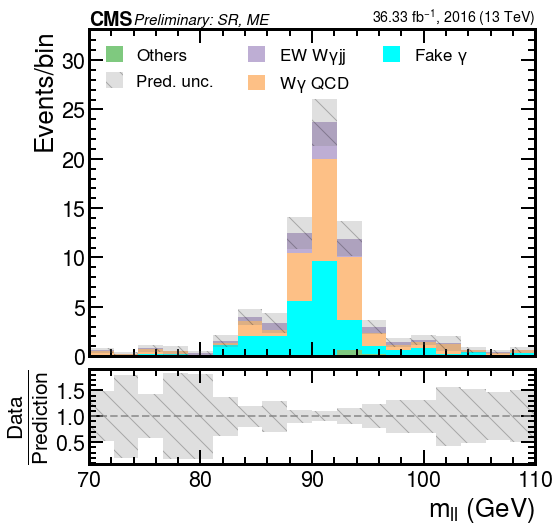

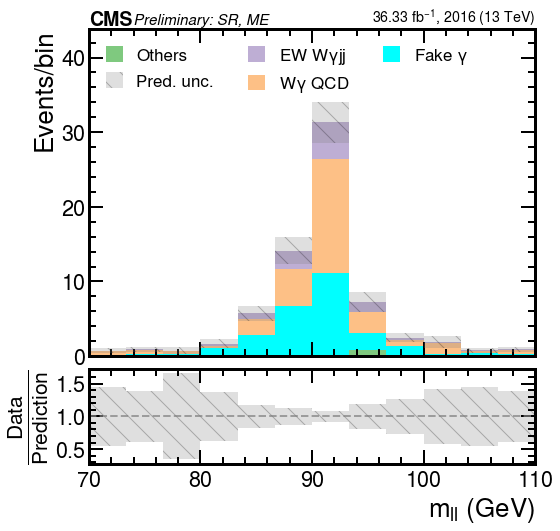

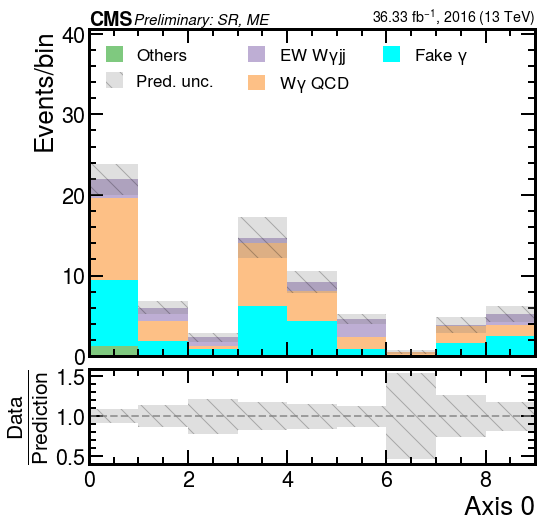

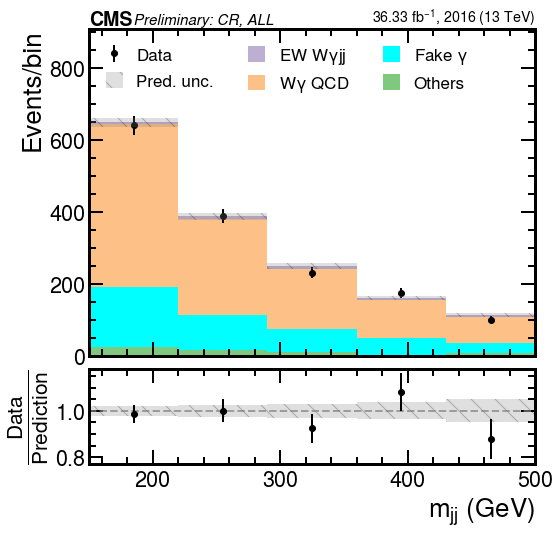

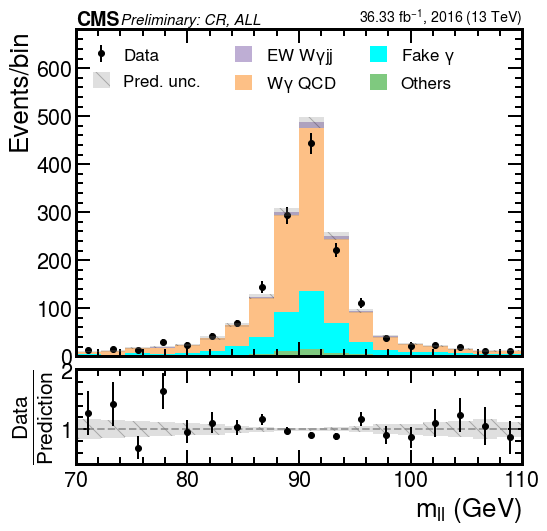

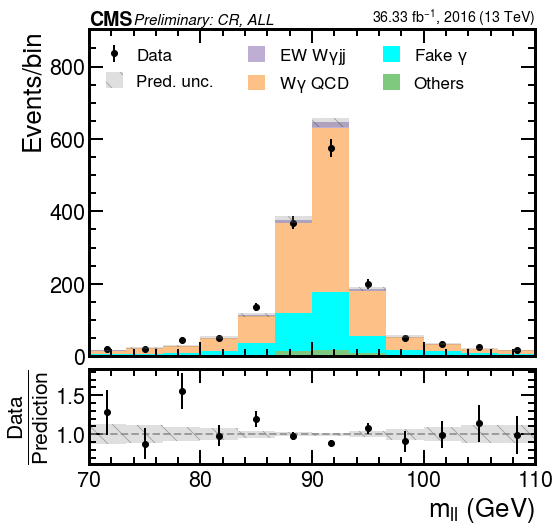

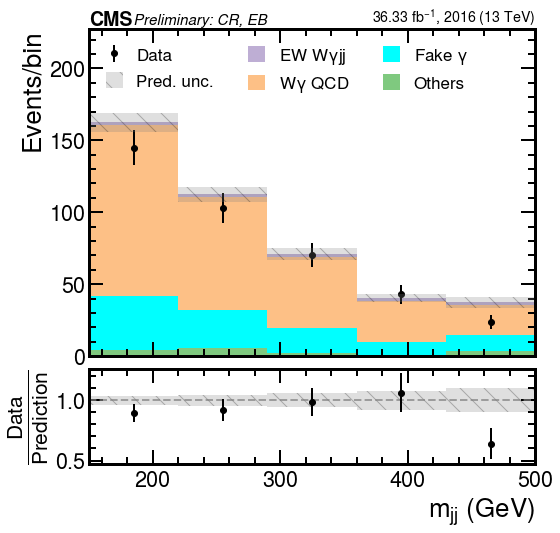

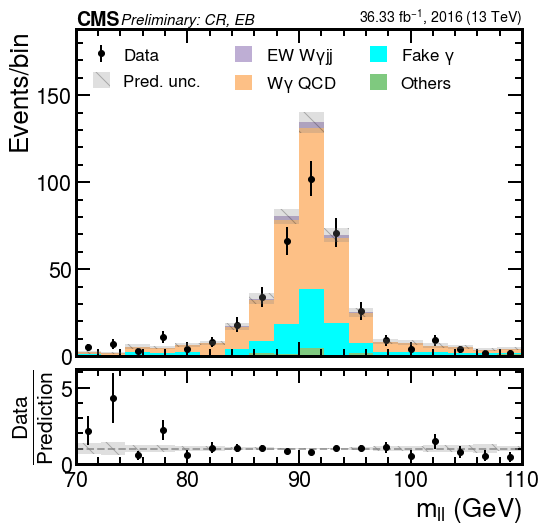

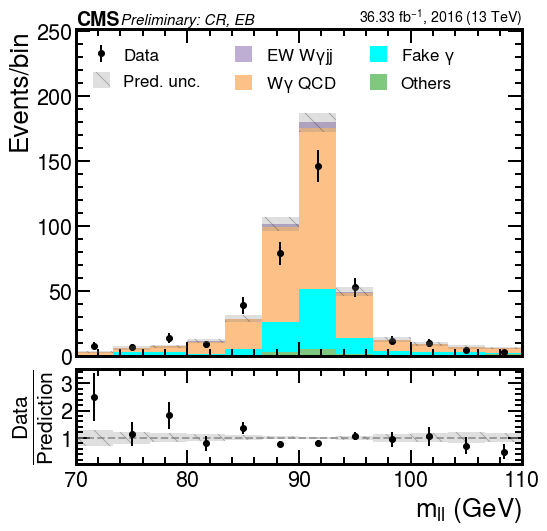

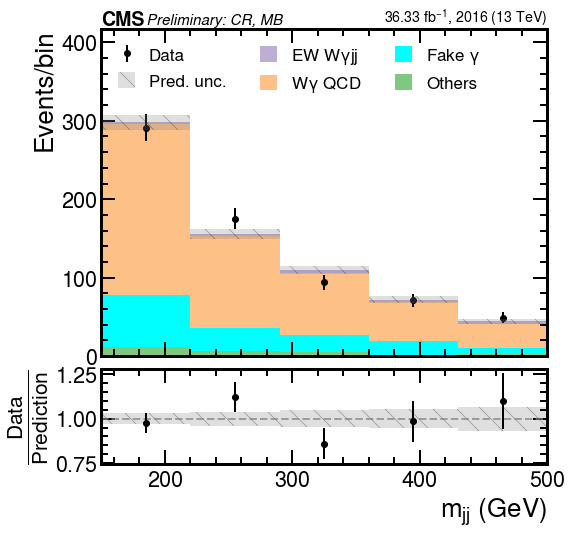

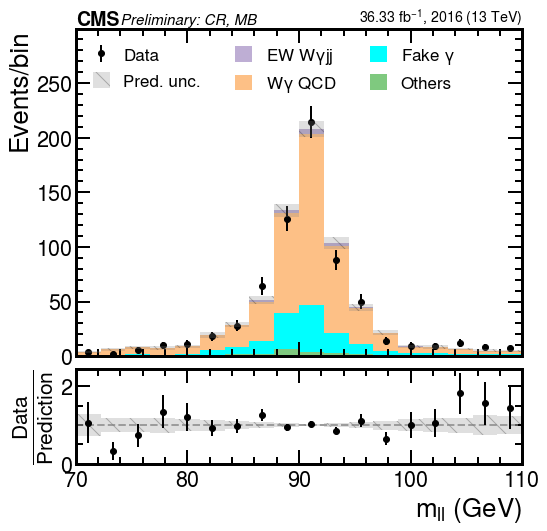

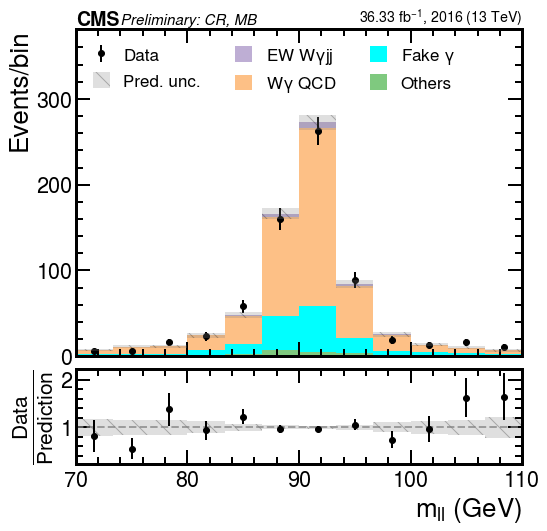

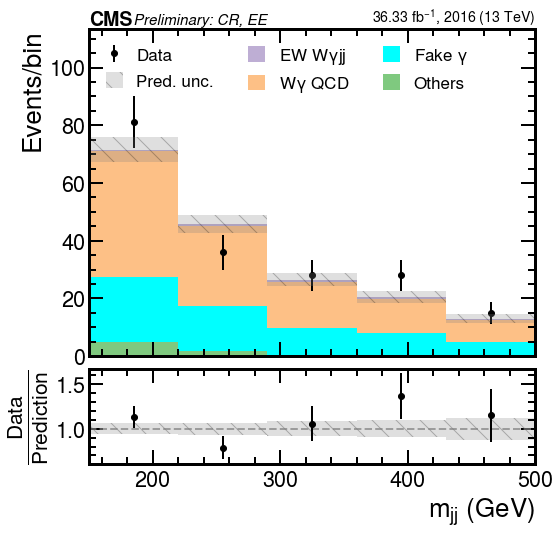

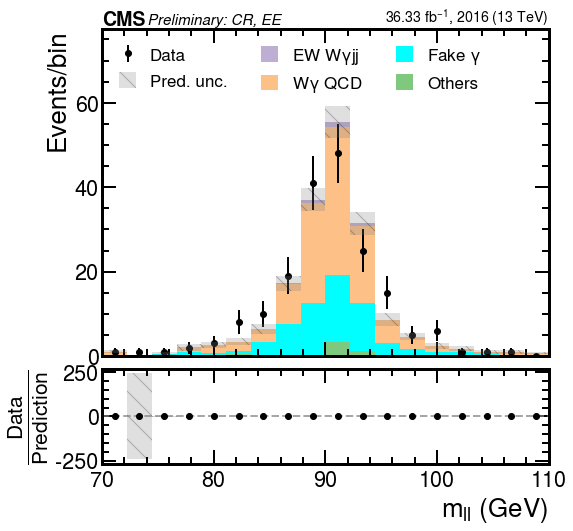

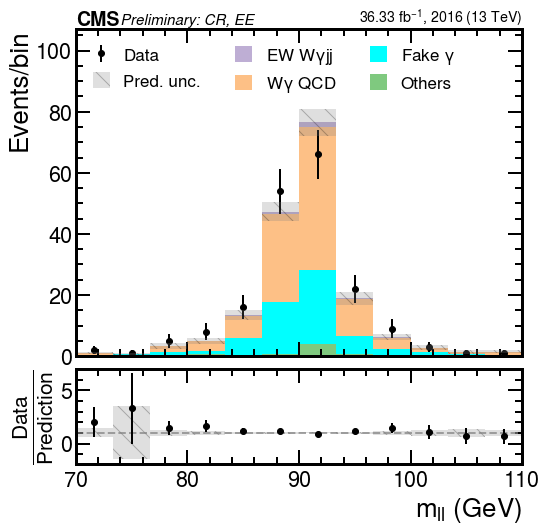

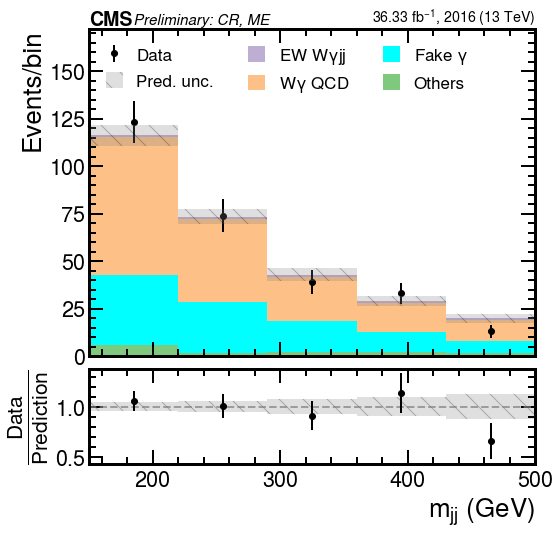

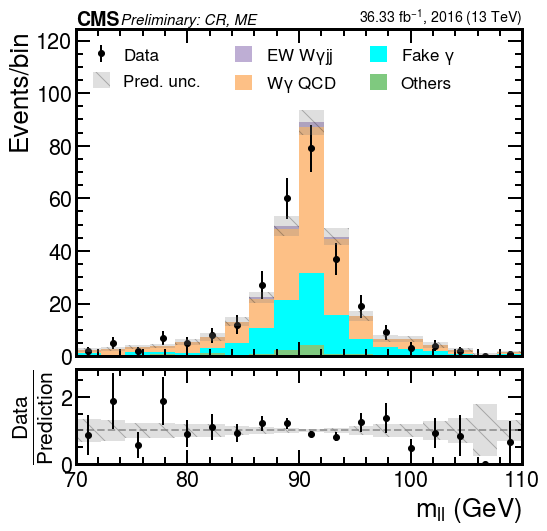

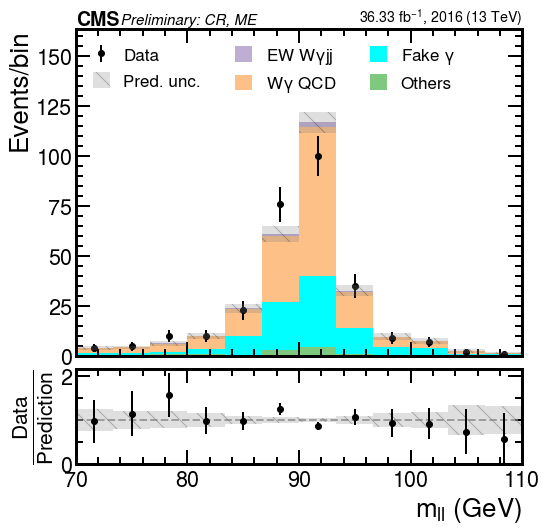

In [4]:
with open("plots/plot_2016.pkl", "rb") as f:
    hists = pickle.load(f)

for iregion in hists:
    for ichannel in hists[iregion]:
        for ivar in hists[iregion][ichannel]:
            # if ivar == "mll":
            if True:
                print("============> 2016:",iregion,ichannel,ivar)
                if iregion=="SR":
                    get_plot(iregion,ichannel,ivar,hists[iregion][ichannel][ivar],year="2016",blind=True)
                else:
                    get_plot(iregion,ichannel,ivar,hists[iregion][ichannel][ivar],year="2016",blind=False)

## 2017

============> 2017: SR ALL mjj_detajj
============> 2017: SR EB mjj_detajj
============> 2017: SR MB mjj_detajj
============> 2017: SR EE mjj_detajj
============> 2017: SR ME mjj_detajj


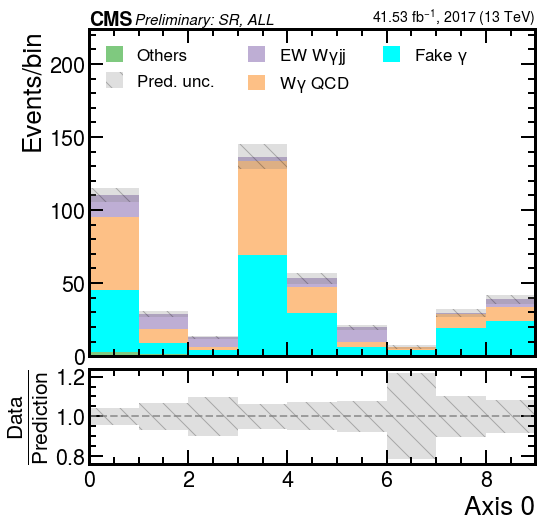

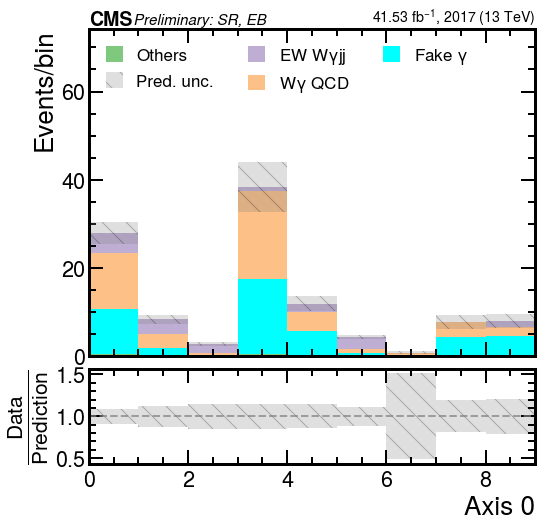

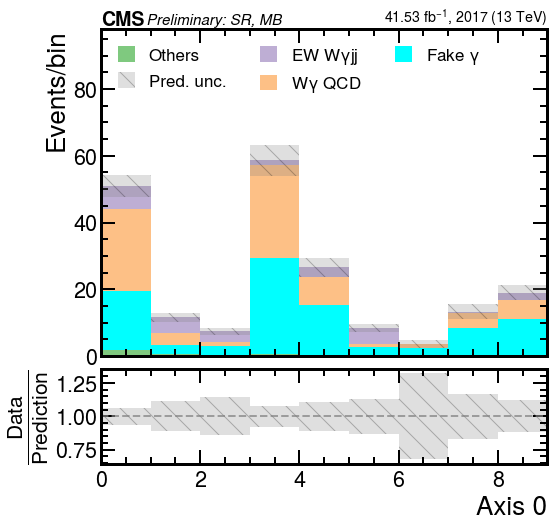

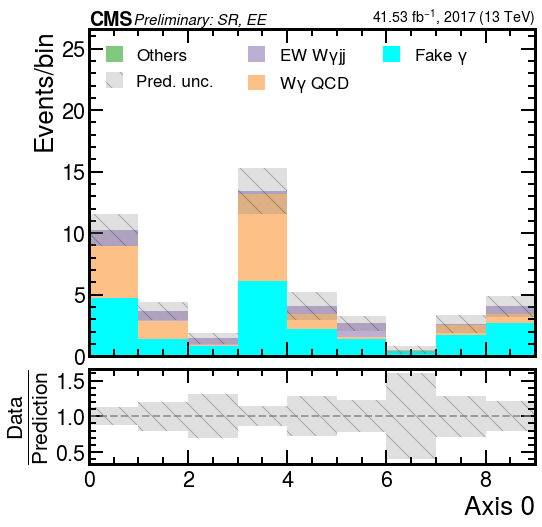

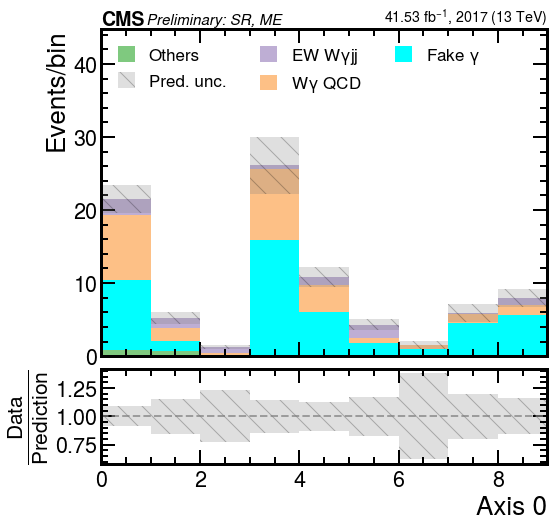

In [5]:
with open("plots/plot_2017.pkl", "rb") as f:
    hists = pickle.load(f)

for iregion in hists:
    for ichannel in hists[iregion]:
        for ivar in hists[iregion][ichannel]:
            if ivar == "mjj_detajj":
            # if True:
                print("============> 2017:",iregion,ichannel,ivar)
                if iregion=="SR":
                    get_plot(iregion,ichannel,ivar,hists[iregion][ichannel][ivar],year="2017",blind=True)
                else:
                    get_plot(iregion,ichannel,ivar,hists[iregion][ichannel][ivar],year="2017",blind=False)

## combine

============> 2016+2017: SR ALL mjj_detajj
============> 2016+2017: SR EB mjj_detajj
============> 2016+2017: SR MB mjj_detajj
============> 2016+2017: SR EE mjj_detajj
============> 2016+2017: SR ME mjj_detajj


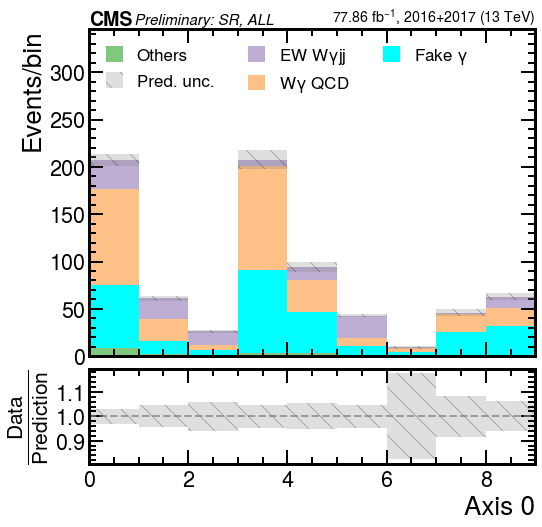

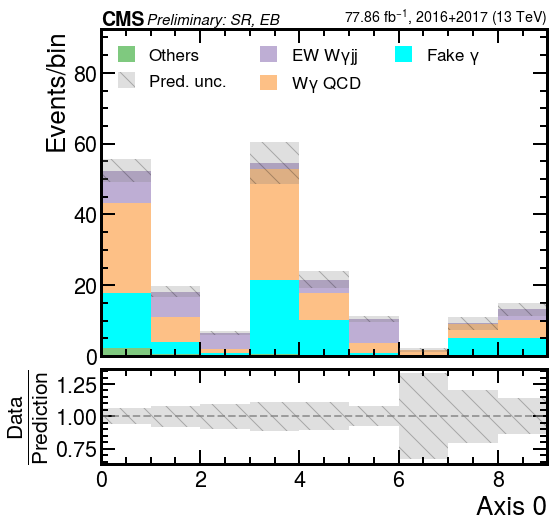

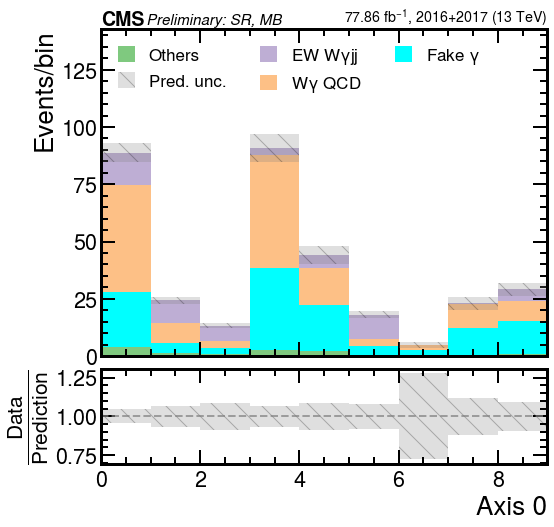

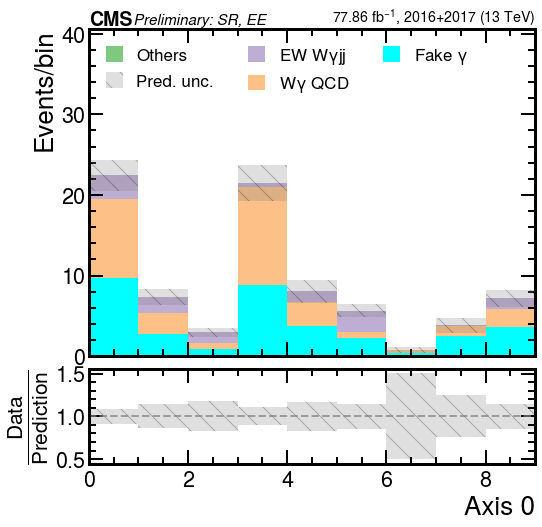

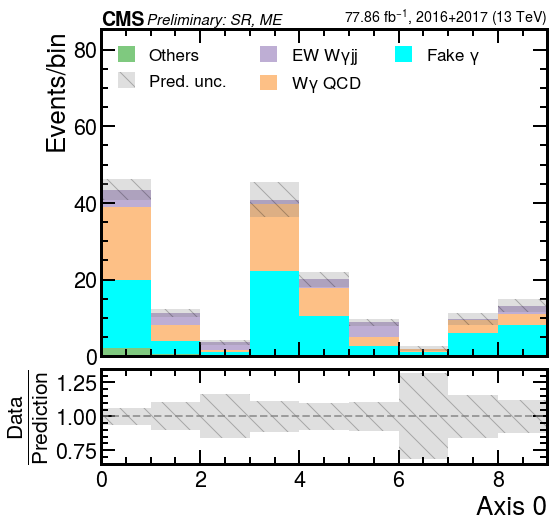

In [8]:
with open("plots/plot_combine.pkl", "rb") as f:
    hists = pickle.load(f)

for iregion in hists:
    for ichannel in hists[iregion]:
        for ivar in hists[iregion][ichannel]:
            if ivar == "mjj_detajj":
            # if True:
                print("============> 2016+2017:",iregion,ichannel,ivar)
                if iregion=="SR":
                    get_plot(iregion,ichannel,ivar,hists[iregion][ichannel][ivar],year="ALL",blind=True)
                else:
                    get_plot(iregion,ichannel,ivar,hists[iregion][ichannel][ivar],year="ALL",blind=False)